# Analysis for Build Components, CogSci 2024

In [1]:
import os
import sys
import urllib, io
import pickle

import random
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.metrics import euclidean_distances, jaccard_score, pairwise_distances

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 
from IPython.core.display import HTML 

from io import BytesIO
import base64
import requests

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from matplotlib.colors import ListedColormap

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

sys.path.append("../../stimuli/block_utils/")
import blockworld_utils as utils
import domino_settings as dominoes
import domino_settings_monochrome as mono_dominoes

import importlib


/Users/will/opt/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
experiment_name = 'build_components/cogsci24'

## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')

# paths specific to this experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots/')
# csv_dir = os.path.join(experiment_results_dir,'csv')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
# if not os.path.exists(results_dir):
#     os.makedirs(results_dir)
    
# if not os.path.exists(plot_dir):
#     os.makedirs(plot_dir)   
    
# if not os.path.exists(csv_dir):
#     os.makedirs(csv_dir)       

## utils

In [3]:
def parallel_bootstrap(df, 
                        bootstrap_column = 'gameID',
                        condition_column = 'condition',
                        value_columns = ['response_correct'],
                        n_iter = 1000,
                        seed = 0,
                        stat = np.mean):
    '''
    Bootstrap a distribution of means values for a given statistic while 
    keeping values of the bootstrapped column consistent across sample distributions.
    This can be used to e.g. sample the same participants in each iteration number.
    '''

    random.seed(seed)
    
    dists = {}
    empirical_stat = {}

    if condition_column != None:
        conditions = df[condition_column].unique()
    else:
        conditions = None

    grouped = df.groupby([bootstrap_column] + [condition_column])
    groups = df[bootstrap_column].unique()
    n_groups = df[bootstrap_column].nunique()

    grouped_stat = grouped[value_columns].apply(stat) 

    for condition in conditions:
        dists[condition] = []
        empirical_stat[condition] = np.mean(grouped_stat.loc[[(group, condition) for group in groups]])
        

    for i in range(n_iter):

        sample = random.choices(groups, k=n_groups)

        for condition in conditions:
            sample_values = grouped_stat.loc[[(group, condition) for group in sample]]
            sample_mean = np.mean(sample_values)
            dists[condition].append(sample_mean)

    
    return dists, empirical_stat

def bootstrap(df, bootstrap_column = 'gameID', condition_columns = ['condition'], value_columns = ['response'], n_iter = 1000, stat = np.mean):
    '''
    Bootstrap a distribution of means values for a given statistic.
    '''
    
    aggregate_values = [] # list of means of statistic for each sample


    df_build_dists_baseline_all = pd.DataFrame()
    grouped = df.groupby([bootstrap_column] + condition_columns)
    groups = df[bootstrap_column].unique()
    grouped_stat = grouped[value_columns].apply(stat) # apply statistic to each group 

    for i in range(n_iter):
        # sample groups to get list of statistics
        sample = grouped_stat.sample(n=grouped.ngroups, replace=True).reset_index(drop=True)
        
        aggregate_values.append(np.mean(sample))
    
    return aggregate_values

def bootstrapped_ci(data, conf_level=0.95):
    lower_bound = np.percentile(data, 100*(1-conf_level)/2)
    upper_bound = np.percentile(data, 100-100*(1-conf_level)/2)
    return lower_bound, upper_bound

def print_result(dist, empirical, conf_level=0.95):
    ci = bootstrapped_cis(dist, conf_level=conf_level)
    print('(${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(empirical, *ci))
    

def p_val(dist1, dist2):
    
    assert(len(dist1) == len(dist2))
    
    p = sum(np.array(dist1) < np.array(dist2)) / len(dist1)
    
    return p


def ci_errorbar_values(dists, mean_dict, order = ['foil','build','view']):
    
    ci_lower = []
    ci_upper = []
    means = []
    
    for condition in order:
        ci = bootstrapped_ci(dists[condition])
        ci_lower.append(ci[0])
        ci_upper.append(ci[1])
    
    means = [mean_dict[condition] for condition in order]
    
    ci_error = [[mean - lower for mean, lower in zip(means, ci_lower)],
                [upper - mean for mean, upper in zip(means, ci_upper)]]
    
    
    return {'means': means, 'error_diffs' : ci_error}


# Calculate 95% CI for each group
def create_ci(data, conf_level=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)
    ci = sem * stats.t.ppf((1 + conf_level) / 2, len(data) - 1)
    
#     print('[{:.3g}, {:.3g}]'.format(mean - ci, mean + ci))
    
    return mean - ci, mean + ci

In [4]:
### Extra block utils

def get_block_map(blocks):
    return utils.worldify(ast.literal_eval(blocks)).block_map[2:,0:4]

def mean_tower(group):
    return np.mean(group['square_map'])

In [5]:
sns.set_style('whitegrid', {'font.family':'sans-serif', 'font.sans-serif':'Avenir'})
import poster_plot_settings
from poster_plot_settings import palette

In [6]:
# import stim dataframes
df_towers = pd.read_csv('../../stimuli/block_utils/ambiguous/ambiguous_composite_towers.csv')
df_towers['tower_id'] = df_towers.tower_id_tall

In [7]:
condition_order = ['foil','build','view']

# Experiment 1: Recognition

In [8]:
# which iteration name should we use?
subfolder = 'recognition'

iteration_name = 'build_components_pilot_2'

### Load csvs from dataframe generator

df_trial = pd.read_csv(results_dir + '/' + subfolder + '/csv/df_trial_{}.csv'.format(iteration_name))

df_recog = df_trial[df_trial.trial_type == "block-tower-old-new"].reset_index().drop(columns=['index', 'Unnamed: 0'])

df_encode = df_trial[~(df_trial.trial_type == "block-tower-old-new")].reset_index().drop(columns=['index', 'Unnamed: 0'])

df_blocks = pd.read_csv(results_dir + '/' + subfolder + '/csv/df_blocks_{}.csv'.format(iteration_name))

In [9]:
df_recog = df_recog.merge(df_towers[['tower_id','stim_wide']], on = 'tower_id')
df_recog['square_map'] = df_recog['stim_wide'].apply(lambda x: get_block_map(x))

### add columns

In [10]:
df_recog['novelty'] = ['new' if condition == 'foil' else 'old' for condition in df_recog.condition]

In [11]:
# double check accuracy calculations
df_recog['response_correct_recalc'] = ((df_recog.response_meaning == 'new') & (df_recog.condition == 'foil')) | \
                                       ((df_recog.response_meaning == 'old') & (df_recog.condition != 'foil'))

df_recog['response_correct_recalc'].equals(df_recog['response_correct'].astype(bool))

True

In [12]:
df_recog['responded_old'] = df_recog.response_meaning.apply(lambda x: 1 if x=='old' else 0)

In [13]:
# Export for stats
save = False

if save:
    filename = '../../../results/recognition/csv/df_recog_vss.csv'
    df_recog.to_csv(filename)
    print(filename)

### response/ recognition accuracy

In [14]:
# bootstrap distributions of mean response
# keeping participants' data together (i.e. sampled ppt n is the same across all distributions)
response_dists, response_means = parallel_bootstrap(df_recog, 
                    bootstrap_column = 'gameID',
                    condition_column = 'condition',
                    value_columns = ['responded_old'],
                    n_iter = 1000,
                    stat = np.mean)

In [15]:
print('foil (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(response_means['foil'], *bootstrapped_ci(response_dists['foil'])))
print('build (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(response_means['build'], *bootstrapped_ci(response_dists['build'])))
print('view (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(response_means['view'], *bootstrapped_ci(response_dists['view'])))


# p_val(dists['view'], dists['build'])

print(p_val(response_dists['view'], response_dists['build']))
print(p_val(response_dists['build'], response_dists['foil']))
print(p_val(response_dists['view'], response_dists['foil']))

foil ($0.33,\ 95\%\ CI: [0.283,\ 0.377]$)
build ($0.59,\ 95\%\ CI: [0.527,\ 0.653]$)
view ($0.743,\ 95\%\ CI: [0.683,\ 0.793]$)
0.0
0.0
0.0


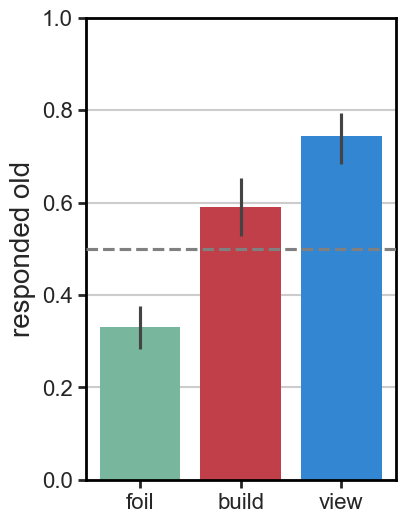

In [16]:
fig = plt.figure()

sns.barplot(data = df_recog, 
            y = "responded_old", 
            order = condition_order,
            hue = "condition",
            x = "condition",
            errorbar=None,
#             yerr = ci_error,
            palette=palette)

cis = ci_errorbar_values(response_dists, 
                         response_means, 
                         order = condition_order)

plt.errorbar(y = cis['means'], 
             x = [0,1,2], 
             yerr= cis['error_diffs'],
             ecolor = '#444444',
             fmt='none')

plt.ylim((0,1))
plt.axhline(0.5, color = 'gray', linestyle = '--',)
plt.ylabel('responded old')
plt.xlabel('')


for spine in fig.gca().spines.values():
    spine.set_zorder(1)
    spine.set_color('black')
    
plt.savefig(plot_dir + 'recog_response.pdf', bbox_inches='tight')

# plt.show()

#### old vs. new stimuli

In [17]:
# bootstrap keeping participants' data together (i.e. sampled ppt n is the same across all distributions)
response_dists_novelty, response_means_novelty = parallel_bootstrap(df_recog, 
                    bootstrap_column = 'gameID',
                    condition_column = 'novelty',
                    value_columns = ['responded_old'],
                    n_iter = 1000,
                    stat = np.mean)

print('old (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(response_means_novelty['old'], *bootstrapped_ci(response_dists_novelty['old'])))
print('new (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(response_means_novelty['new'], *bootstrapped_ci(response_dists_novelty['new'])))
print(p_val(response_dists_novelty['old'], response_dists_novelty['new']))

old ($0.667,\ 95\%\ CI: [0.62,\ 0.708]$)
new ($0.33,\ 95\%\ CI: [0.283,\ 0.377]$)
0.0


# Experiment 2: Recall

# Experiment 3 + 4 read in data

In [18]:
# final iteration names are suffixes of csvs

csv_ids = {
    "ve_on" : "build_components_cogsci_ve_old_new_prolific_pilot_0",
    "ve_re": "build_components_cogsci_ve_recall_prolific_pilot_0",
    "wm_on" : "build_components_cogsci_wm_old_new_prolific_pilot_0",
    "wm_re": "build_components_cogsci_wm_recall_prolific_pilot_0"
}

experiment_results_dir

'/Users/will/zipping/results/build_components/cogsci24'

In [19]:
# read in all dataframes

dfs = {}

for i, (k, v) in enumerate(csv_ids.items()):
    dfs[k] = {}
    dfs[k]['encode'] = pd.read_csv(experiment_results_dir + '/df_encode_{}.csv'.format(v))
    dfs[k]['decode'] = pd.read_csv(experiment_results_dir + '/df_decode_{}.csv'.format(v))
    dfs[k]['block'] = pd.read_csv(experiment_results_dir + '/df_block_{}.csv'.format(v))
    dfs[k]['construct'] = pd.read_csv(experiment_results_dir + '/df_construction_procedure_{}.csv'.format(v))
    
dfs['ve_re']['recalls'] = pd.read_csv(experiment_results_dir + 
                                '/df_recalled_towers_{}.csv'.format(csv_ids['ve_re']))
dfs['wm_re']['recalls'] = pd.read_csv(experiment_results_dir + 
                                '/df_recalled_towers_{}.csv'.format(csv_ids['wm_re']))

In [20]:
def exclude_ppts(dfg, excluded):
    dfg['encode'] = dfg['encode'][~dfg['encode'].gameID.isin(excluded)].reset_index()
    dfg['decode'] = dfg['decode'][~dfg['decode'].gameID.isin(excluded)].reset_index()
    dfg['block'] = dfg['block'][~dfg['block'].gameID.isin(excluded)].reset_index()
    dfg['construct'] =dfg['construct'][~dfg['construct'].gameID.isin(excluded)].reset_index()

In [21]:
dfs['ve_on']['decode'].loc[:, 'responded_old'] = dfs['ve_on']['decode'].response_meaning == 'old'
dfs['wm_on']['decode'].loc[:, 'responded_old'] = dfs['wm_on']['decode'].response_meaning == 'old'

# Experiment 3: Encoding type for recognition

In [22]:
# appply exclusion criteria
df = dfs['ve_on']

print('{} ppts to start with'.format(df['encode'].gameID.nunique()))

excluded = []

# didn't complete all encoding trials
incomplete = df['encode'].groupby('gameID').apply(len) < 12
excluded += list(set(incomplete.index[incomplete]))
print('{} ppts removed for incomplete encoding phase'.format(len(list(incomplete.index[incomplete]))))

# didn't complete all decode trials
incomplete_decode = df['decode'].groupby('gameID').apply(len) < 12
excluded += list(incomplete_decode.index[incomplete_decode])
print('{} ppts removed for incomplete decoding phase'.format(len(list(incomplete_decode.index[incomplete_decode]))))

# >90% response with same key
response_mean = df['decode'].groupby('gameID').apply(lambda g: np.mean(g.responded_old))
key_mashing = (response_mean > 0.9) | (response_mean < 0.1)
excluded += list(key_mashing.index[key_mashing])
print('{} ppts removed for key mashing'.format(len(list(key_mashing.index[key_mashing]))))

# 10 mins between end of encode and start of decode
e_time = df['encode'].groupby('gameID').last().reset_index()[['gameID','timeAbsolute']]
d_time = df['decode'].groupby('gameID').first().reset_index()[['gameID','trial_start_time']]
time_diff = e_time.merge(d_time, on = 'gameID', how = 'outer')
time_diff = time_diff[~(time_diff.timeAbsolute.isna() | time_diff.trial_start_time.isna())]
time_diff.loc[:, 'between_phase_time'] = (time_diff.trial_start_time-time_diff.timeAbsolute)/60000
big_wait = (time_diff.loc[:, 'between_phase_time'] > 10)
excluded += list(set((big_wait.index[big_wait])))
print('{} ppts removed for waiting too long between phases'.format(len(list(big_wait.index[big_wait]))))

print('{} ppts remaining'.format(df['encode'][~df['encode'].gameID.isin(excluded)].gameID.nunique()))
exclude_ppts(df, excluded)

56 ppts to start with
6 ppts removed for incomplete encoding phase
0 ppts removed for incomplete decoding phase
0 ppts removed for key mashing
0 ppts removed for waiting too long between phases
50 ppts remaining


In [23]:
# appply exclusion criteria
df = dfs['ve_re']

print('{} ppts to start with'.format(df['encode'].gameID.nunique()))

excluded = []

# didn't complete all encoding trials
incomplete = df['encode'].groupby('gameID').apply(len) < 12
excluded += list(set(incomplete.index[incomplete]))
print('{} ppts removed for incomplete encoding phase'.format(len(list(incomplete.index[incomplete]))))

# didn't complete all decode trials
incomplete_decode = df['decode'].groupby('gameID').apply(len) < 1
excluded += list(incomplete_decode.index[incomplete_decode])
print('{} ppts removed for incomplete decoding phase'.format(len(list(incomplete_decode.index[incomplete_decode]))))

# 10 mins between end of encode and start of decode
e_time = df['encode'].groupby('gameID').last().reset_index()[['gameID','timeAbsolute']]
d_time = df['decode'].groupby('gameID').first().reset_index()[['gameID','trial_start_time']]
time_diff = e_time.merge(d_time, on = 'gameID', how = 'outer')
time_diff = time_diff[~(time_diff.timeAbsolute.isna() | time_diff.trial_start_time.isna())]
time_diff.loc[:, 'between_phase_time'] = (time_diff.trial_start_time-time_diff.timeAbsolute)/60000
big_wait = (time_diff.loc[:, 'between_phase_time'] > 10)
excluded += list(set((big_wait.index[big_wait])))
print('{} ppts removed for waiting too long between phases'.format(len(list(big_wait.index[big_wait]))))

print('{} ppts remaining'.format(df['encode'][~df['encode'].gameID.isin(excluded)].gameID.nunique()))
exclude_ppts(df, excluded)

55 ppts to start with
5 ppts removed for incomplete encoding phase
0 ppts removed for incomplete decoding phase
1 ppts removed for waiting too long between phases
50 ppts remaining


## visual exposure

In [24]:
dfs['ve_on']['decode']['novelty'] = ['new' if condition == 'foil' else 'old' for condition in dfs['ve_on']['decode'].condition]

In [25]:
# bootstrap keeping participants' data together (i.e. sampled ppt n is the same across all distributions)
ve_response_dists, ve_response_means = parallel_bootstrap(dfs['ve_on']['decode'], 
                                                    bootstrap_column = 'gameID',
                                                    condition_column = 'condition',
                                                    value_columns = ['responded_old'],
                                                    n_iter = 1000,
                                                    stat = np.mean)

In [26]:
print('foil (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(ve_response_means['foil'], *bootstrapped_ci(ve_response_dists['foil'])))
print('build (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(ve_response_means['build'], *bootstrapped_ci(ve_response_dists['build'])))
print('view (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(ve_response_means['view'], *bootstrapped_ci(ve_response_dists['view'])))

print(p_val(ve_response_dists['view'], ve_response_dists['build']))
print(p_val(ve_response_dists['build'], ve_response_dists['foil']))
print(p_val(ve_response_dists['view'], ve_response_dists['foil']))

foil ($0.29,\ 95\%\ CI: [0.243,\ 0.34]$)
build ($0.78,\ 95\%\ CI: [0.713,\ 0.847]$)
view ($0.833,\ 95\%\ CI: [0.753,\ 0.9]$)
0.173
0.0
0.0


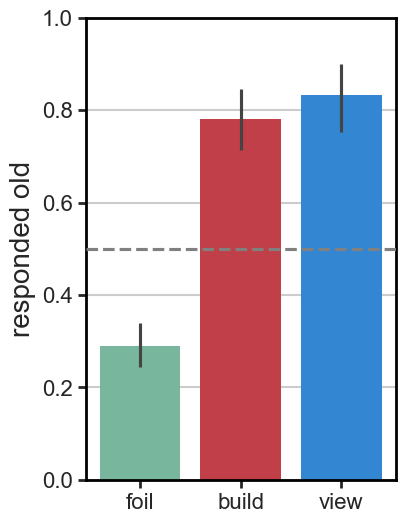

In [27]:
fig = plt.figure()

sns.barplot(data = dfs['ve_on']['decode'], 
            y = "responded_old", 
            order = condition_order,
            hue = "condition",
            x = "condition",
            errorbar=None,
            palette=palette)

cis = ci_errorbar_values(ve_response_dists, 
                         ve_response_means, 
                         order = condition_order)

plt.errorbar(y = cis['means'], 
             x = [0,1,2], 
             yerr= cis['error_diffs'],
             ecolor = '#444444',
             fmt='none')

plt.ylim((0,1))
plt.axhline(0.5, color = 'gray', linestyle = '--',)
plt.ylabel('responded old')
plt.xlabel('')


for spine in fig.gca().spines.values():
    spine.set_zorder(1)
    spine.set_color('black')

plt.savefig(plot_dir + 'encode_ve_recog_response.pdf', bbox_inches='tight')

plt.show()

In [28]:
# bootstrap keeping participants' data together (i.e. sampled ppt n is the same across all distributions)
ve_response_dists_novelty, ve_response_means_novelty = parallel_bootstrap(dfs['ve_on']['decode'], 
                    bootstrap_column = 'gameID',
                    condition_column = 'novelty',
                    value_columns = ['responded_old'],
                    n_iter = 1000,
                    stat = np.mean)

print('old (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(ve_response_means_novelty['old'], *bootstrapped_ci(ve_response_dists_novelty['old'])))
print('new (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(ve_response_means_novelty['new'], *bootstrapped_ci(ve_response_dists_novelty['new'])))

# p_val(dists['view'], dists['build'])

print(p_val(ve_response_dists_novelty['old'], ve_response_dists_novelty['new']))

# df_recog.novelty

old ($0.807,\ 95\%\ CI: [0.76,\ 0.853]$)
new ($0.29,\ 95\%\ CI: [0.243,\ 0.34]$)
0.0


### working memory

In [29]:
dfs['wm_on']['decode']['novelty'] = ['new' if condition == 'foil' else 'old' for condition in dfs['wm_on']['decode'].condition]

In [30]:
# bootstrap keeping participants' data together (i.e. sampled ppt n is the same across all distributions)
wm_response_dists, wm_response_means = parallel_bootstrap(dfs['wm_on']['decode'], 
                                                    bootstrap_column = 'gameID',
                                                    condition_column = 'condition',
                                                    value_columns = ['responded_old'],
                                                    n_iter = 1000,
                                                    stat = np.mean)

In [31]:
print('foil (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(wm_response_means['foil'], *bootstrapped_ci(wm_response_dists['foil'])))
print('build (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(wm_response_means['build'], *bootstrapped_ci(wm_response_dists['build'])))
print('view (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(wm_response_means['view'], *bootstrapped_ci(wm_response_dists['view'])))

print(p_val(wm_response_dists['view'], wm_response_dists['build']))
print(p_val(wm_response_dists['build'], wm_response_dists['foil']))
print(p_val(wm_response_dists['view'], wm_response_dists['foil']))

foil ($0.275,\ 95\%\ CI: [0.222,\ 0.33]$)
build ($0.876,\ 95\%\ CI: [0.824,\ 0.922]$)
view ($0.876,\ 95\%\ CI: [0.83,\ 0.915]$)
0.498
0.0
0.0


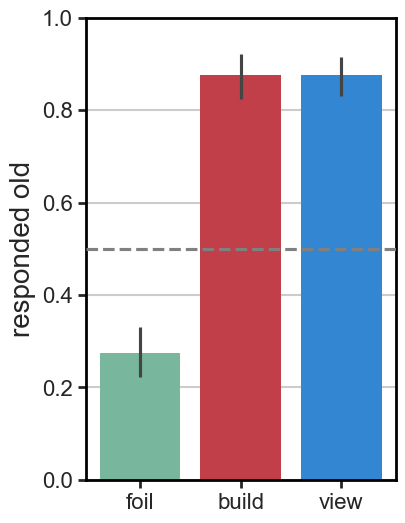

In [32]:
fig = plt.figure()

sns.barplot(data = dfs['wm_on']['decode'], 
            y = "responded_old", 
            order = condition_order,
            hue = "condition",
            x = "condition",
            errorbar=None,
            palette=palette)

cis = ci_errorbar_values(wm_response_dists, 
                         wm_response_means, 
                         order = condition_order)

plt.errorbar(y = cis['means'], 
             x = [0,1,2], 
             yerr= cis['error_diffs'],
             ecolor = '#444444',
             fmt='none')

plt.ylim((0,1))
plt.axhline(0.5, color = 'gray', linestyle = '--',)
plt.ylabel('responded old')
plt.xlabel('')


for spine in fig.gca().spines.values():
    spine.set_zorder(1)
    spine.set_color('black')

plt.savefig(plot_dir + 'encode_wm_recog_response.pdf', bbox_inches='tight')

plt.show()

In [33]:
# bootstrap keeping participants' data together (i.e. sampled ppt n is the same across all distributions)
wm_response_dists_novelty, wm_response_means_novelty = parallel_bootstrap(dfs['wm_on']['decode'], 
                    bootstrap_column = 'gameID',
                    condition_column = 'novelty',
                    value_columns = ['responded_old'],
                    n_iter = 1000,
                    stat = np.mean)

print('old (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(wm_response_means_novelty['old'], *bootstrapped_ci(wm_response_dists_novelty['old'])))
print('new (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(wm_response_means_novelty['new'], *bootstrapped_ci(wm_response_dists_novelty['new'])))

# p_val(dists['view'], dists['build'])

print(p_val(wm_response_dists_novelty['old'], wm_response_dists_novelty['new']))

# df_recog.nowmlty

old ($0.876,\ 95\%\ CI: [0.843,\ 0.908]$)
new ($0.275,\ 95\%\ CI: [0.222,\ 0.33]$)
0.0


# Experiment 4: Encoding type for recall

In [34]:
# appply exclusion criteria
df = dfs['wm_on']

print('{} ppts to start with'.format(df['encode'].gameID.nunique()))

excluded = []

# didn't complete all encoding trials
incomplete = df['encode'].groupby('gameID').apply(len) < 24
excluded += list(set(incomplete.index[incomplete]))
print('{} ppts removed for incomplete encoding phase'.format(len(list(incomplete.index[incomplete]))))

# didn't complete all decode trials
incomplete_decode = df['decode'].groupby('gameID').apply(len) < 12
excluded += list(incomplete_decode.index[incomplete_decode])
print('{} ppts removed for incomplete decoding phase'.format(len(list(incomplete_decode.index[incomplete_decode]))))

# >90% response with same key
response_mean = df['decode'].groupby('gameID').apply(lambda g: np.mean(g.responded_old))
key_mashing = (response_mean > 0.9) | (response_mean < 0.1)
excluded += list(key_mashing.index[key_mashing])
print('{} ppts removed for key mashing'.format(len(list(key_mashing.index[key_mashing]))))

# 10 mins between end of encode and start of decode
e_time = df['encode'].groupby('gameID').last().reset_index()[['gameID','timeAbsolute']]
d_time = df['decode'].groupby('gameID').first().reset_index()[['gameID','trial_start_time']]
time_diff = e_time.merge(d_time, on = 'gameID', how = 'outer')
time_diff = time_diff[~(time_diff.timeAbsolute.isna() | time_diff.trial_start_time.isna())]
time_diff.loc[:, 'between_phase_time'] = (time_diff.trial_start_time-time_diff.timeAbsolute)/60000
big_wait = (time_diff.loc[:, 'between_phase_time'] > 10)
excluded += list(set((big_wait.index[big_wait])))
print('{} ppts removed for waiting too long between phases'.format(len(list(big_wait.index[big_wait]))))

print('{} ppts remaining'.format(df['encode'][~df['encode'].gameID.isin(excluded)].gameID.nunique()))
exclude_ppts(df, excluded)

55 ppts to start with
4 ppts removed for incomplete encoding phase
0 ppts removed for incomplete decoding phase
0 ppts removed for key mashing
0 ppts removed for waiting too long between phases
51 ppts remaining


In [35]:
# appply exclusion criteria
df = dfs['wm_re']

print('{} ppts to start with'.format(df['encode'].gameID.nunique()))

excluded = []

# didn't complete all encoding trials
incomplete = df['encode'].groupby('gameID').apply(len) < 24
excluded += list(set(incomplete.index[incomplete]))
print('{} ppts removed for incomplete encoding phase'.format(len(list(incomplete.index[incomplete]))))

# didn't complete all decode trials
incomplete_decode = df['decode'].groupby('gameID').apply(len) < 1
excluded += list(incomplete_decode.index[incomplete_decode])
print('{} ppts removed for incomplete decoding phase'.format(len(list(incomplete_decode.index[incomplete_decode]))))

# 10 mins between end of encode and start of decode
e_time = df['encode'].groupby('gameID').last().reset_index()[['gameID','timeAbsolute']]
d_time = df['decode'].groupby('gameID').first().reset_index()[['gameID','trial_start_time']]
time_diff = e_time.merge(d_time, on = 'gameID', how = 'outer')
time_diff = time_diff[~(time_diff.timeAbsolute.isna() | time_diff.trial_start_time.isna())]
time_diff.loc[:, 'between_phase_time'] = (time_diff.trial_start_time-time_diff.timeAbsolute)/60000
big_wait = (time_diff.loc[:, 'between_phase_time'] > 10)
excluded += list(set((big_wait.index[big_wait])))
print('{} ppts removed for waiting too long between phases'.format(len(list(big_wait.index[big_wait]))))

print('{} ppts remaining'.format(df['encode'][~df['encode'].gameID.isin(excluded)].gameID.nunique()))
exclude_ppts(df, excluded)

51 ppts to start with
1 ppts removed for incomplete encoding phase
0 ppts removed for incomplete decoding phase
0 ppts removed for waiting too long between phases
50 ppts remaining
